# Tarea Semanal 5: Simulación de un ADC (cuantización, muestreo y alias)
## Magdalena Noé
Se simulará un ADC incluyendo capacidad de muestrear a $fs$ [Hz], con una señal analogica muestreada a $f's= ko.fs$, siendo $ko$ el factor de sobremuestreo. Se adoptará una potencia de ruido analógico igual al ruido de cuantización.

Primero se generarán dichas señales, con y sin oversampling, analizando sus diferencias.

Luego se aplicará un filtro pasabajos a la señal con oversampling, eliminando el alias, para apreciar la ventaja en definición que trae esta práctica. 

Finalmente se plantearán 4 casos en donde no se usa el filtro pasabajos de forma correcta, demostrando el efecto alias y las consecuencias que tiene en la señal.

### Librerias

In [297]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, filtfilt, freqz
import scipy.signal as sig
from numpy.fft import fft #Para poder escribir fft() en vez de numpy.fft.fft()
import pandas as pd # Para las tablas

### Parametros generales

In [298]:
fs = 1000       # Frecuencia de muestreo [Hz]
N = fs          # cantidad de muestras
fo = fs/N * 10  # 10 [Hz]
ts = 1 / fs

ko = 10         # Factor de sobremuestreo
fs_os = fs * ko # Frec de muestreo con oversamp: 1000*ko [Hz]
N_os = N * ko   # cantidad de muestras con oversamp

Vmax = np.sqrt(2) #[Volts] Amplitud señal
df = fs/N # Resolución espectral

# RUIDO #
Vf = 2 #[Volts] 
B = 4 # Bits
q = Vf/2**(B)

kn = 1
Pq = q**2/12
Pn = kn * Pq # Pot ruido [Watts]

### Generación, contaminación y cuantificación de la señal (Con y sin OverSampling)

In [299]:
tt = np.arange(0, N) * ts               # Arr temporal para frecuencia de muestreo ts
s = Vmax * np.sin(tt*2*np.pi*fo)        # Señal normal

tt_os = np.arange(0, N_os) * (ts / ko)          # Arr temporal para frecuencia de muestreo oversampleada
s_os = Vmax * np.sin(tt_os*2*np.pi*fo)    # Señal con oversampling

n = np.random.normal(loc=0, scale=np.sqrt(Pn), size=N) # Ruido

sr = s + n                            # Señal sin cuantizar pero con ruido
#srq = q * np.floor(sr / q + 0.5)     # Señal cuantizada
srq = np.round(sr / q) * q            # Señal cuantizada
nq = srq - sr                         # Error de cuantización

n_os = np.random.normal(loc=0, scale=np.sqrt(Pn), size=N_os) # Ruido con tamaño para oversampleado

sr_os = s_os + n_os                        # Señal sin cuantizar pero con ruido
srq_os = np.round(sr_os / q) * q        # Señal cuantizada
nq_os = srq_os - sr_os                  # Error de cuantización

Graficamos las señales para apreciar sus diferencias

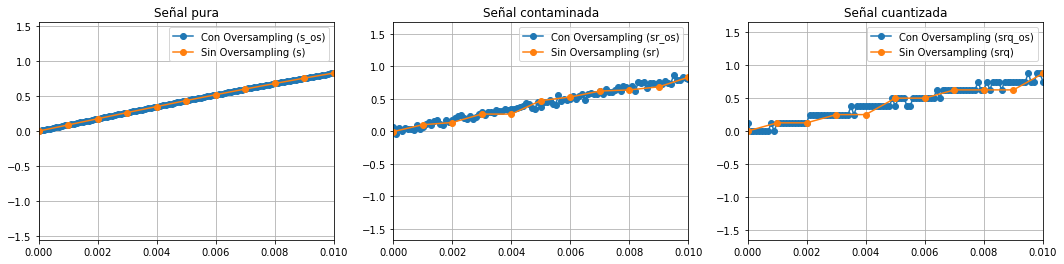

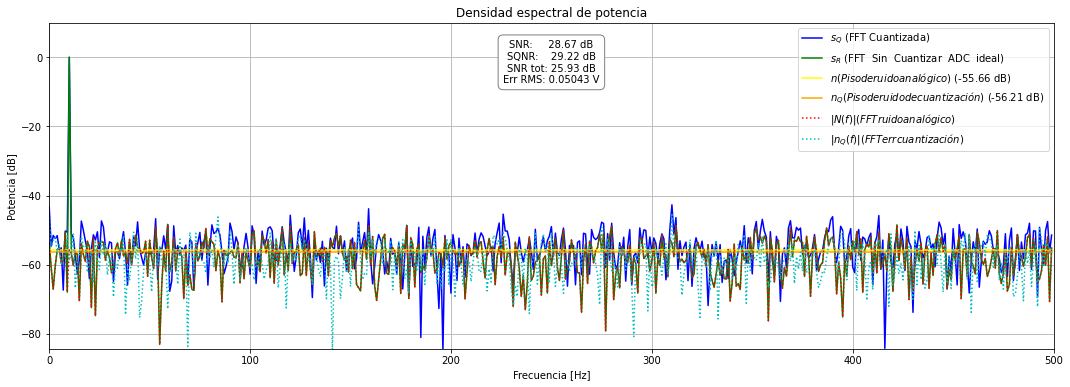

In [300]:
### Graficos temporales ###
plt.figure(figsize=(18, 4))

plt.subplot(1,3,1)
plt.plot(tt_os, s_os, 'o-', label='Con Oversampling (s_os)')
plt.plot(tt, s, 'o-', label='Sin Oversampling (s)')
plt.legend(); plt.grid();  plt.xlim(0, 0.01);plt.title("Señal pura")

plt.subplot(1,3,2)
plt.plot(tt_os, sr_os, 'o-', label='Con Oversampling (sr_os)')
plt.plot(tt, sr, 'o-', label='Sin Oversampling (sr)')
plt.legend(); plt.grid();  plt.xlim(0, 0.01);plt.title("Señal contaminada")

plt.subplot(1,3,3)
plt.plot(tt_os, srq_os, 'o-', label='Con Oversampling (srq_os)')
plt.plot(tt, srq, 'o-', label='Sin Oversampling (srq)')
plt.legend(); plt.grid();  plt.xlim(0, 0.01);plt.title("Señal cuantizada")
plt.show()

### Defino este grafico como una funcion ya que lo voy a estar repitiendo para cada caso de filtrado ###

def graficar_densidad_potencia(s, sr, srq, n, nq, fs, titulo='Densidad espectral de potencia'):
    """
    Grafica la densidad espectral de potencia (PSD) de una señal cuantizada, su versión sin cuantizar,
    el ruido analógico y el error de cuantización, incluyendo los pisos de ruido.

    Parámetros:
    - s: señal pura (sin ruido ni cuantización)
    - sr: señal con ruido
    - srq: señal cuantizada
    - n: ruido analógico
    - nq: error de cuantización (srq - sr)
    - fs: frecuencia de muestreo [Hz]
    - titulo: título del gráfico
    """
    # Esto acata al caso en donde al corregir el corrimiento de fase de la
    # señal filtrada esta cambia en su largo de array. Se recortan todos al
    # largo minimo para evitar incompatibilidad de largos en el analisis
    min_len = min(len(s), len(sr), len(srq), len(n), len(nq))
    s = s[:min_len]
    sr = sr[:min_len]
    srq = srq[:min_len]
    n = n[:min_len]
    nq = nq[:min_len]

    ts = 1 / fs
    ff = np.fft.fftfreq(min_len, d=ts)

    # FFTs
    ft_S = fft(s) / min_len
    ft_SR = fft(sr) / min_len
    ft_Srq = fft(srq) / min_len
    ft_N = fft(n) / min_len
    ft_Nq = fft(nq) / min_len

    # Potencias
    P_s = np.mean(np.abs(ft_S)**2)
    P_n = np.mean(np.abs(ft_N)**2)
    P_nq = np.mean(np.abs(ft_Nq)**2)
    P_ruido_tot = P_n + P_nq

    # Pisos de ruido
    n_valor_db = 10 * np.log10(2 * P_n)
    nq_valor_db = 10 * np.log10(2 * P_nq)
    s_valor_db = 10 * np.log10(2 * P_s)

    # Métricas
    SNR = 10 * np.log10(P_s / P_n)
    SQNR = 10 * np.log10(P_s / P_nq)
    SNR_total = 10 * np.log10(P_s / P_ruido_tot)
    RMS_error = np.sqrt(np.mean((s - srq)**2))

    # Gráfico
    bfrec = (ff >= 0) & (ff <= fs / 2)
    ff_valid = ff[bfrec]

    curvas = [
        ('$s_Q$ (FFT Cuantizada)', ff_valid, 10 * np.log10(2 * np.abs(ft_Srq[bfrec])**2), 'b', '-'),
        ('$s_R$ (FFT  Sin  Cuantizar  ADC  ideal)', ff_valid, 10 * np.log10(2 * np.abs(ft_SR[bfrec])**2), 'g', '-'),
        ('$n (Piso  de  ruido  analógico)$ ({:.2f} dB)'.format(n_valor_db), ff_valid, [n_valor_db] * len(ff_valid), 'yellow', '-'),
        ('$n_Q (Piso  de  ruido  de  cuantización)$ ({:.2f} dB)'.format(nq_valor_db), ff_valid, [nq_valor_db] * len(ff_valid), 'orange', '-'),
        ('$|N(f)| (FFT  ruido  analógico)$', ff_valid, 10 * np.log10(2 * np.abs(ft_N[bfrec])**2), 'r', ':'),
        ('$|n_Q(f)| (FFT  err  cuantización)$', ff_valid, 10 * np.log10(2 * np.abs(ft_Nq[bfrec])**2), 'c', ':'),
    ]

    plt.figure(figsize=(18, 6))
    for titulo_curva, frec, pot, color, estilo in curvas:
        plt.plot(frec, pot, label=titulo_curva, color=color, linestyle=estilo)

    plt.title(titulo)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Potencia [dB]')
    plt.grid(True)
    plt.xlim([0, fs / 2])
    plt.ylim((1.5 * np.min(10 * np.log10(2 * np.array([P_nq, P_n, P_s]))), 10))
    plt.legend()

    # Cajita de estimadores
    texto_metricas = (
        f"SNR:     {SNR:.2f} dB\n"
        f"SQNR:    {SQNR:.2f} dB\n"
        f"SNR tot: {SNR_total:.2f} dB\n"
        f"Err RMS: {RMS_error:.5f} V"
    )
    plt.text(0.5 * fs / 2, 5, texto_metricas,
             fontsize=10, ha='center', va='top',
             bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))

    plt.show()
    return RMS_error, SNR_total

# Densidad de potencia de señal sin oversampling
err_RMS, SNR_tot = graficar_densidad_potencia(s, sr, srq, n, nq, fs)
arr_RMS = [err_RMS]; arr_SNR = [SNR_tot]

### Estimadores: 
- SNR (Signal-to-Noise Ratio). $$10 . log(Pot_{señal} / Pot_{ruido-analogico})$$
- SQNR (Signal-to-Quantization Noise Ratio). $$10 . log(Pot_{señal} / Pot_{ruido-cuantizacion})$$
- SNR total: Proporcion entre la señal y el ruido total del sistema. $$10 . log(\frac{Pot_{señal}}{Pot_{ruido-analog} + Pot_{ruido-cuantz}})$$
- Error RMS: Diferencia entre la señal digital final con la señal analogica ideal sin ruido. $$\sqrt{ \frac{1}{n} \sum_{i=1}^{n} (s_i - srq_i)^2 }$$

Se observa que el ruido intruducido por la cuantización es equiparable al ruido del sistema analógico.

## Filtrado IIR

Planteamos una función para el diseño de filtro IIR Butterworth.

Esta me genera un filtro pasabajos con la frecuencia de corte, orden de filtro y atenuación mínima que indiquen sus parametros, utilizando la funcion `butter()` de scipy.signal. Así mismo grafica la plantilla de dicho filtro.

In [301]:
def graficar_plantilla(b, a, fs, fpass, fstop, fcorte, a_max=0.5, a_min=40, ax=None):
    
    w, h = sig.freqz(b, a, worN=1024, fs=fs)
    f = w / np.pi
    h_db = 20 * np.log10(np.abs(h) + 1e-12)

    if ax is None: # Util para poder usar el grafico en subplots
        ax = plt.gca()  # Usa el eje actual si no se pasa ninguno

    # Grafica
    ax.plot(f, h_db, label='Respuesta en frecuencia', color='blue')
    # Líneas
    ax.axvline(fcorte*(fs/2), color='grey', linestyle=':', label=f'fcorte = {fcorte*(fs/2):.1f} Hz')
    ax.axvline(fpass*(fs/2), color='green', linestyle='--', label=f'fpass = {fpass*(fs/2):.1f} Hz')
    ax.axvline(fstop*(fs/2), color='red', linestyle='--', label=f'fstop = {fstop*(fs/2):.1f} Hz')
    ax.axhline(-a_max, color='green', linestyle='--', label=f'αmax = -{a_max:.1f} dB')
    ax.axhline(-a_min, color='red', linestyle='--', label=f'αmin = -{a_min:.1f} dB')

    # Zonas
    ax.fill_between(w, -a_max, plt.ylim()[1], where=(w <= fpass), color='green', alpha=0.2)
    ax.fill_between(w, -a_min, -500, where=(w >= fstop), color='red', alpha=0.2)

    ax.set_xlabel('Frecuencia [Hz]')
    ax.set_ylabel('Magnitud [dB]')
    ax.set_title('Plantilla de Atenuación del Filtro IIR')
    ax.set_ylim([-100, 5])
    ax.grid(True, which='both', linestyle='--')
    ax.legend()

    if ax is None:
        plt.tight_layout()
        plt.show()


## Filtrado y diezmado de señal oversampleada

A continuacion vamos a realizar el correcto filtrado de la señal oversampleada, es decir, el filtro anti-alias, el cual respetara el limite de Nyquist donde:
$$ f_{corte} = 1/ko $$

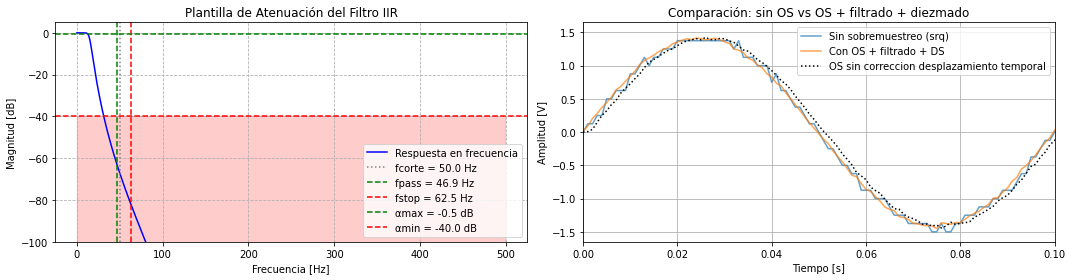

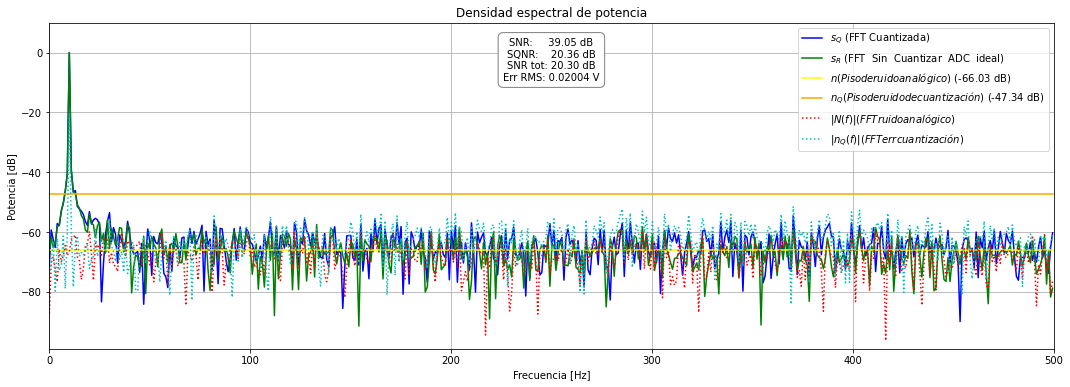

In [302]:
ftran = 0.1
orden = 6
fcorte = 1/ko
fstop = np.min([fcorte + ftran/2, 1/ko * 5/4])  # 
fpass = np.max([fstop - ftran/2, fstop * 3/4]) # Frecuencias ya normalizadas a fs/2

b, a = butter(orden, fpass, btype='low', analog=False)

# Filtrado
srq_os_antialias = lfilter(b, a, srq_os)
sr_os_antialias = lfilter(b, a, sr_os)
n_os_antialias = lfilter(b, a, n_os)

# Correccion desplazamiento
delta = np.zeros(N)
delta[0] = 1
h = lfilter(b, a, delta) # Aplico el filtro creado a una delta
delay_est = np.argmax(np.abs(h)) # Obtengo el corrimiento temporal analizando el corrimiento del delta
srq_os_antialias_desplazado = srq_os_antialias
srq_os_antialias = srq_os_antialias[delay_est:] 
# Corrijo el desplazamiento introducido por el filtro IIR recortando los primeros valores
# De esta manera la "traigo para atras"

# Diezmado
srq_ds = srq_os_antialias[::ko]
tt_ds = tt_os[::ko][:len(srq_ds)]
n_ds = n_os_antialias[::ko][:len(srq_ds)]
sr_ds = sr_os_antialias[::ko][:len(srq_ds)]
srq_os_antialias_desplazado = srq_os_antialias_desplazado[::ko][:len(srq_ds)]
nq_ds = srq_ds - sr_ds # Error de cuantizacion

### GRAFICOS ###
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

# Plantilla filtro
graficar_plantilla(b, a, fs, fpass, fstop, fcorte, a_max=0.5, a_min=40, ax=axs[0])

# Grafico temporal
axs[1].plot(tt, srq, label='Sin sobremuestreo (srq)', alpha=0.7)
axs[1].plot(tt_ds, srq_ds, label='Con OS + filtrado + DS', alpha=0.7)
axs[1].plot(tt_ds, srq_os_antialias_desplazado, ':', label='OS sin correccion desplazamiento temporal', color='black')
axs[1].set_title('Comparación: sin OS vs OS + filtrado + diezmado')
axs[1].set_xlabel('Tiempo [s]')
axs[1].set_ylabel('Amplitud [V]')
axs[1].legend()
axs[1].grid()
axs[1].set_xlim(0, 1/fo)

plt.tight_layout()
plt.show()

# Densidad espectral de potencia 
err_RMS, SNR_tot = graficar_densidad_potencia(s, sr_ds, srq_ds, n_ds, nq_ds, fs)

Se puede apreciar como a partir de los 400 Hz la señal empieza a ser atenuada, indicando el correcto efecto del filtro pasa-bajos.

La desventaja que trae es que el filtro IIR introduce un retardo de grupo que desplaza toda la señal temporalmente. Este desplazamiento se ve ilustrado en el grafico temporal, comparando la señal filtrada (negra) y la misma señal con el desplazamiento corregido (naranja).

El desplazamiento temporal fue corregido pasando una delta por el filtro y evaluando cuanto se corrió de su posición original. En este caso es necesario corregirlo para calcular los estimadores de calidad (SNR, SQNR, SNRtot, ErrRMS), ya que estos se comparan con la señal original. En práctica debería evaluarse según el caso si es necesario corregir este corrimiento, o si no afecta al estudio de la señal.

**Pero no continuaremos el analisis con esta solución**. 
Porque este retardo no es constante para todas las frecuencias. En el analisis temporal de un tono puro como estamos manejando no es evidente, pero esto se aprecia en el piso de ruido de cuantizacion (nq en la PSD). Como no nos interesa el error por distorcion del filtro, en especial si este obstruye el analisis de error por cuantización, utilizaremos otra opción: 

`filtfilt()`

*Apply a digital filter forward and backward to a signal.*
*This function applies a linear digital filter twice, once forward and once backwards. The combined filter has zero phase and a filter order twice that of the original.*

Tiene la desventaja de aumentar el orden del filtro de forma implicita.

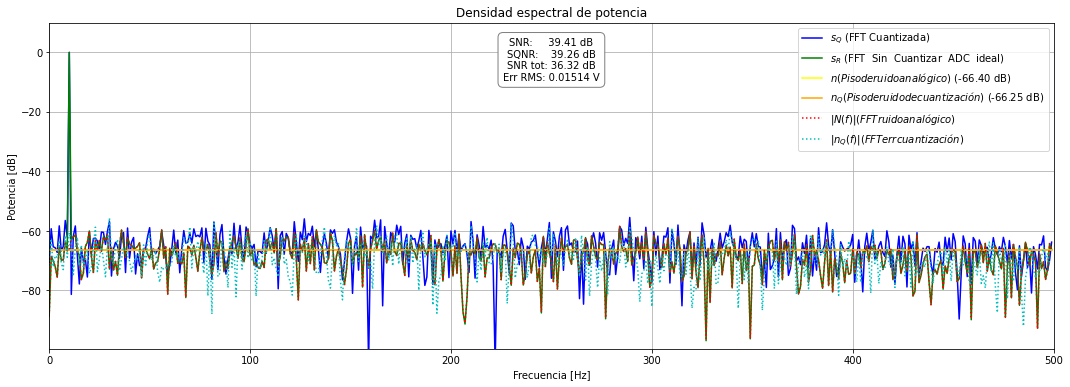

RMS señal sin OS: 0.0504 [V]
RMS señal con OS + Antialias + Diezmado: 0.0151 [V]


In [303]:
# Divido el orden del filtro ya que filtfilt lo estara duplicando
b, a = butter(orden/2, fpass, btype='low', analog=False)

# Filtrado con filtfilt
srq_os_antialias = filtfilt(b, a, srq_os)
sr_os_antialias = filtfilt(b, a, sr_os)
n_os_antialias = filtfilt(b, a, n_os)

# Diezmado
srq_ds = srq_os_antialias[::ko]
tt_ds = tt_os[::ko]
n_ds = n_os_antialias[::ko]
sr_ds = sr_os_antialias[::ko]

nq_ds = srq_ds - sr_ds # Error de cuantizacion

err_RMS, SNR_tot = graficar_densidad_potencia(s, sr_ds, srq_ds, n_ds, nq_ds, fs)
arr_RMS.append(err_RMS); arr_SNR.append(SNR_tot)

print(f"RMS señal sin OS: {arr_RMS[0]:.3} [V]")
print(f"RMS señal con OS + Antialias + Diezmado: {err_RMS:.3} [V]")

## Filtrado incorrecto

Ahora que se aprecio la ventaja del oversampling en conjunto con un filtro anti-alias, observaremos que sucede cuando no se aplica el filtro de manera correcta.

Recordemos, el caso ideal es el cual donde:
$$ f_{corte} = 1/ko$$

Ahora veremos 4 casos donde:
- $f_{corte} << 1/ko$: Nos plantamos exactamente en el limite de Nyquist
- $f_{corte} > 1/ko$: La señal se filtra por encima del limite de Nyquist (ligero efecto alias)
- $f_{corte} >> 1/ko$: Se filtra por debajo del ancho de banda original, perdiendo informacion de la señal innecesariamente
- Señal sin filtro y sobrediezmada

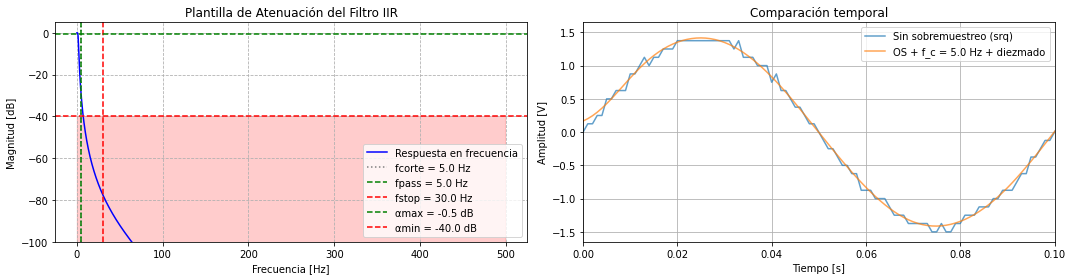

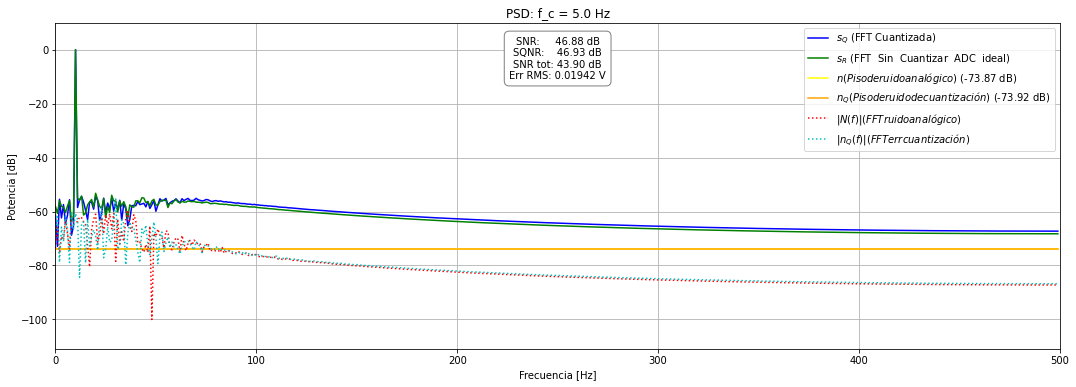

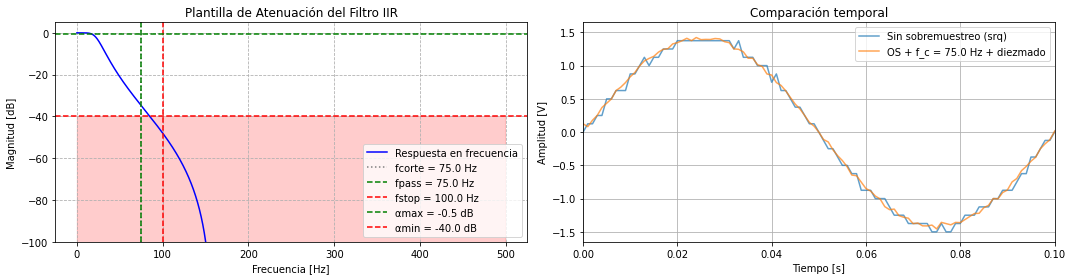

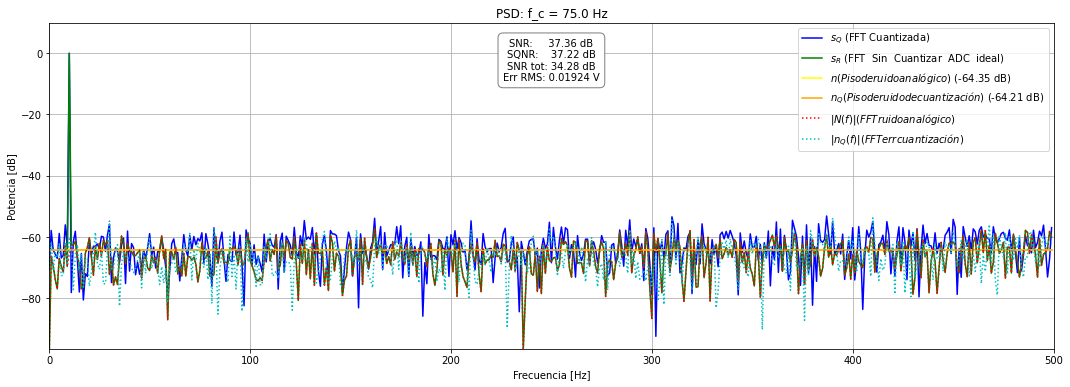

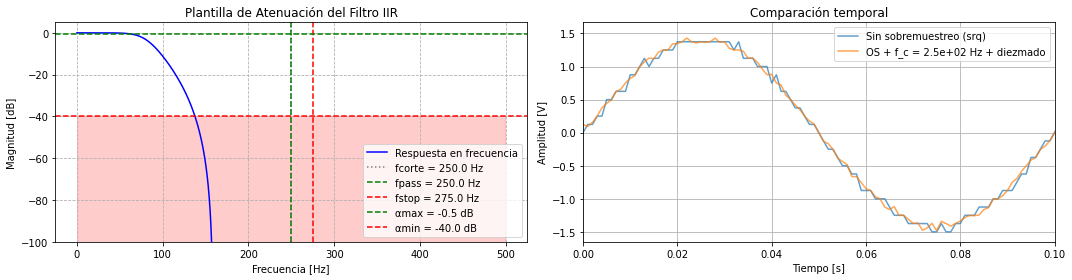

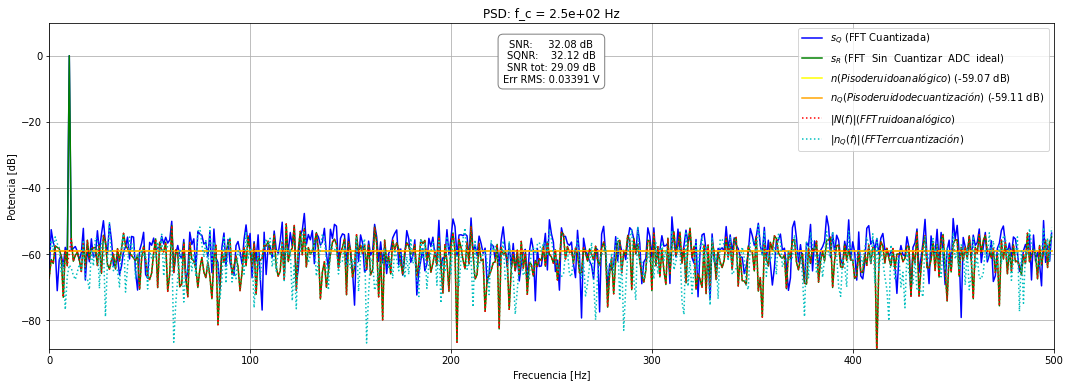

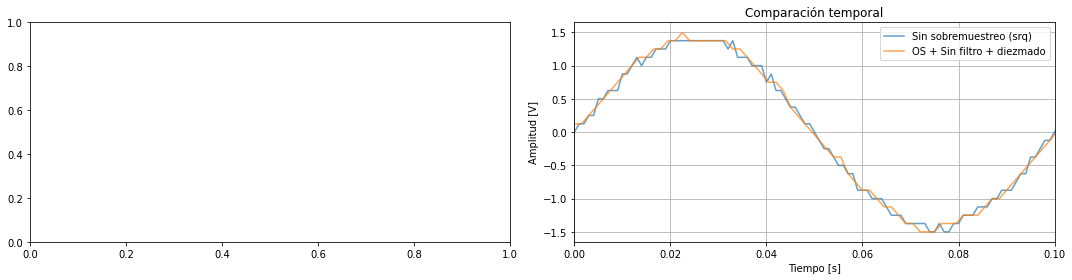

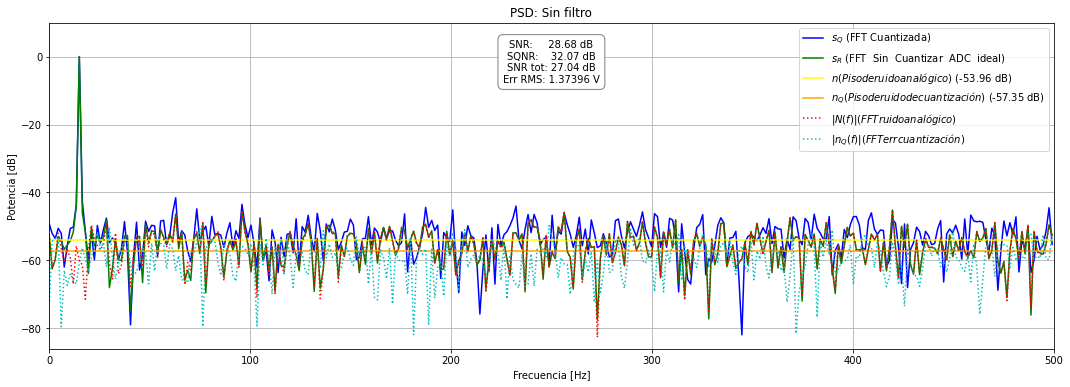

In [304]:
fc_1 = 1/ko * 0.1
fc_2 = 1/ko * 1.5
fc_3 = 1/ko * 5

ftran = 0.1
orden = 6

arr_titulos = [f'f_c = {fc_1*(fs/2):.3} Hz', f'f_c = {fc_2*(fs/2):.3} Hz', f'f_c = {fc_3*(fs/2):.3} Hz', 'Sin filtro']
arr_fcs = [fc_1, fc_2, fc_3]

for i in range(4):
    if( i < 3): # Primeros 3 casos con filtro
        # Creo fitro
        fstop = arr_fcs[i] + ftran/2
        fpass = fstop - ftran/2

        b, a = butter(orden/2, arr_fcs[i], btype='low', analog=False) # Divido el orden del filtro ya que filtfilt lo estara duplicando

        # Filtrado
        srq_os_antialias = filtfilt(b, a, srq_os)
        sr_os_antialias = filtfilt(b, a, sr_os)
        n_os_antialias = filtfilt(b, a, n_os)

        # Diezmado
        srq_ds = srq_os_antialias[::ko]
        tt_ds = tt_os[::ko]
        n_ds = n_os_antialias[::ko]
        sr_ds = sr_os_antialias[::ko]
        nq_ds = srq_ds - sr_ds # Error de cuantizacion

    else: # Caso sin filtro
        # Diezmado
        axs[0].set_title(arr_titulos[i])
        srq_ds = srq_os[::15]  # No filtro la señal
        tt_ds = tt_os[::15]
        n_ds = n_os[::15]# No filtro el ruido de oversampling
        sr_ds = sr_os[::15] # No filtro la señal con ruido con oversampling

    ### GRAFICOS ### 
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    if( i < 3):
       graficar_plantilla(b, a, fs, fpass, fstop, arr_fcs[i], a_max=0.5, a_min=40, ax=axs[0])

    axs[1].plot(tt, srq, label='Sin sobremuestreo (srq)', alpha=0.7)
    axs[1].plot(tt_ds, srq_ds, label=f'OS + {arr_titulos[i]} + diezmado', alpha=0.7)
    axs[1].set_title('Comparación temporal')
    axs[1].set_xlabel('Tiempo [s]')
    axs[1].set_ylabel('Amplitud [V]')
    axs[1].legend()
    axs[1].grid()
    axs[1].set_xlim(0, 1 / fo)

    plt.tight_layout()
    plt.show()

    # PSD
    err_RMS, SNR_tot = graficar_densidad_potencia(s=s, sr=sr_ds, srq=srq_ds, n=n_ds, nq=nq_ds, fs=fs, titulo=f'PSD: {arr_titulos[i]}')
    arr_RMS.append(err_RMS); arr_SNR.append(SNR_tot)

## Observaciones

In [305]:
arr_fcs = [i * (fs/2) for i in arr_fcs]
df_amp = pd.DataFrame({
    'Señal': ['Sin Oversampling','f_c = 1/ko = 50 Hz']+arr_titulos,
    'RMS (Error Cuadratico Medio) [V]': arr_RMS,
    'RMS / RMS sin OS': arr_RMS/arr_RMS[0],
    'SNR (ruido analog+cuant) [dB]': arr_SNR,
})
df_amp

,Señal,RMS (Error Cuadratico Medio) [V],RMS / RMS sin OS,SNR (ruido analog+cuant) [dB]
0,Sin Oversampling,0.050432,1.000000,25.927119
1,f_c = 1/ko = 50 Hz,0.015144,0.300293,36.322778
2,f_c = 5.0 Hz,0.019418,0.385031,43.896607
3,f_c = 75.0 Hz,0.019243,0.381566,34.276459
4,f_c = 2.5e+02 Hz,0.033906,0.672304,29.093043
5,Sin filtro,1.373957,27.243758,27.041005


Se observa que la señal digitalizada de mejor calidad coincide con lo esperado; correspondiendo a la señal con el correcto filtrado y diezmado.
Pero el efecto antialias no parece apreciarse en los casos de filtrado incorrecto.